In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from src.model.eegnet_variance import EEGNetMultiHeaded
from src.model.eegnet import EEGNet
from pytorch_lightning.loggers import CometLogger
from src.datamodule import DataModule, predictDataSet
from src.preprocessing import create_dataset
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.preprocessing import *
import pandas as pd
import torch
import shap


c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\marti_wfv2bf9\AppData\Local\Programs\Python\Python39\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-ji

Section for visualizing data:

In [3]:
files = get_raw_file_paths('src/pickle_df')

# Load one dataframe
df = pd.read_pickle(files[0])

In [4]:
import torch
torch.cuda.is_available()

True

In [14]:
subjects = 6
sessions = 2
       
trials = [[[[], []]for _ in range(sessions)] for _ in range(subjects)]

for file in files:
    subject = int(file.split('/')[-1][8]) - 1
    session = int(file.split('/')[-1][11]) - 1
    recordings = process_recording(file)

    for recording in zip(recordings[0], recordings[1]):
        if recording[1] == 0:
            trials[subject][session][0].append(recording[0])
        elif recording[1] == 1:
            trials[subject][session][1].append(recording[0])

In [15]:
mean_trials = []

for i, subject in enumerate(trials):
    mean_trials.append([])
    for session in subject:
        mean_trials[i].append((
            np.mean(np.array(session[0]), axis=0),
            np.mean(np.array(session[1]), axis=0)
        ))

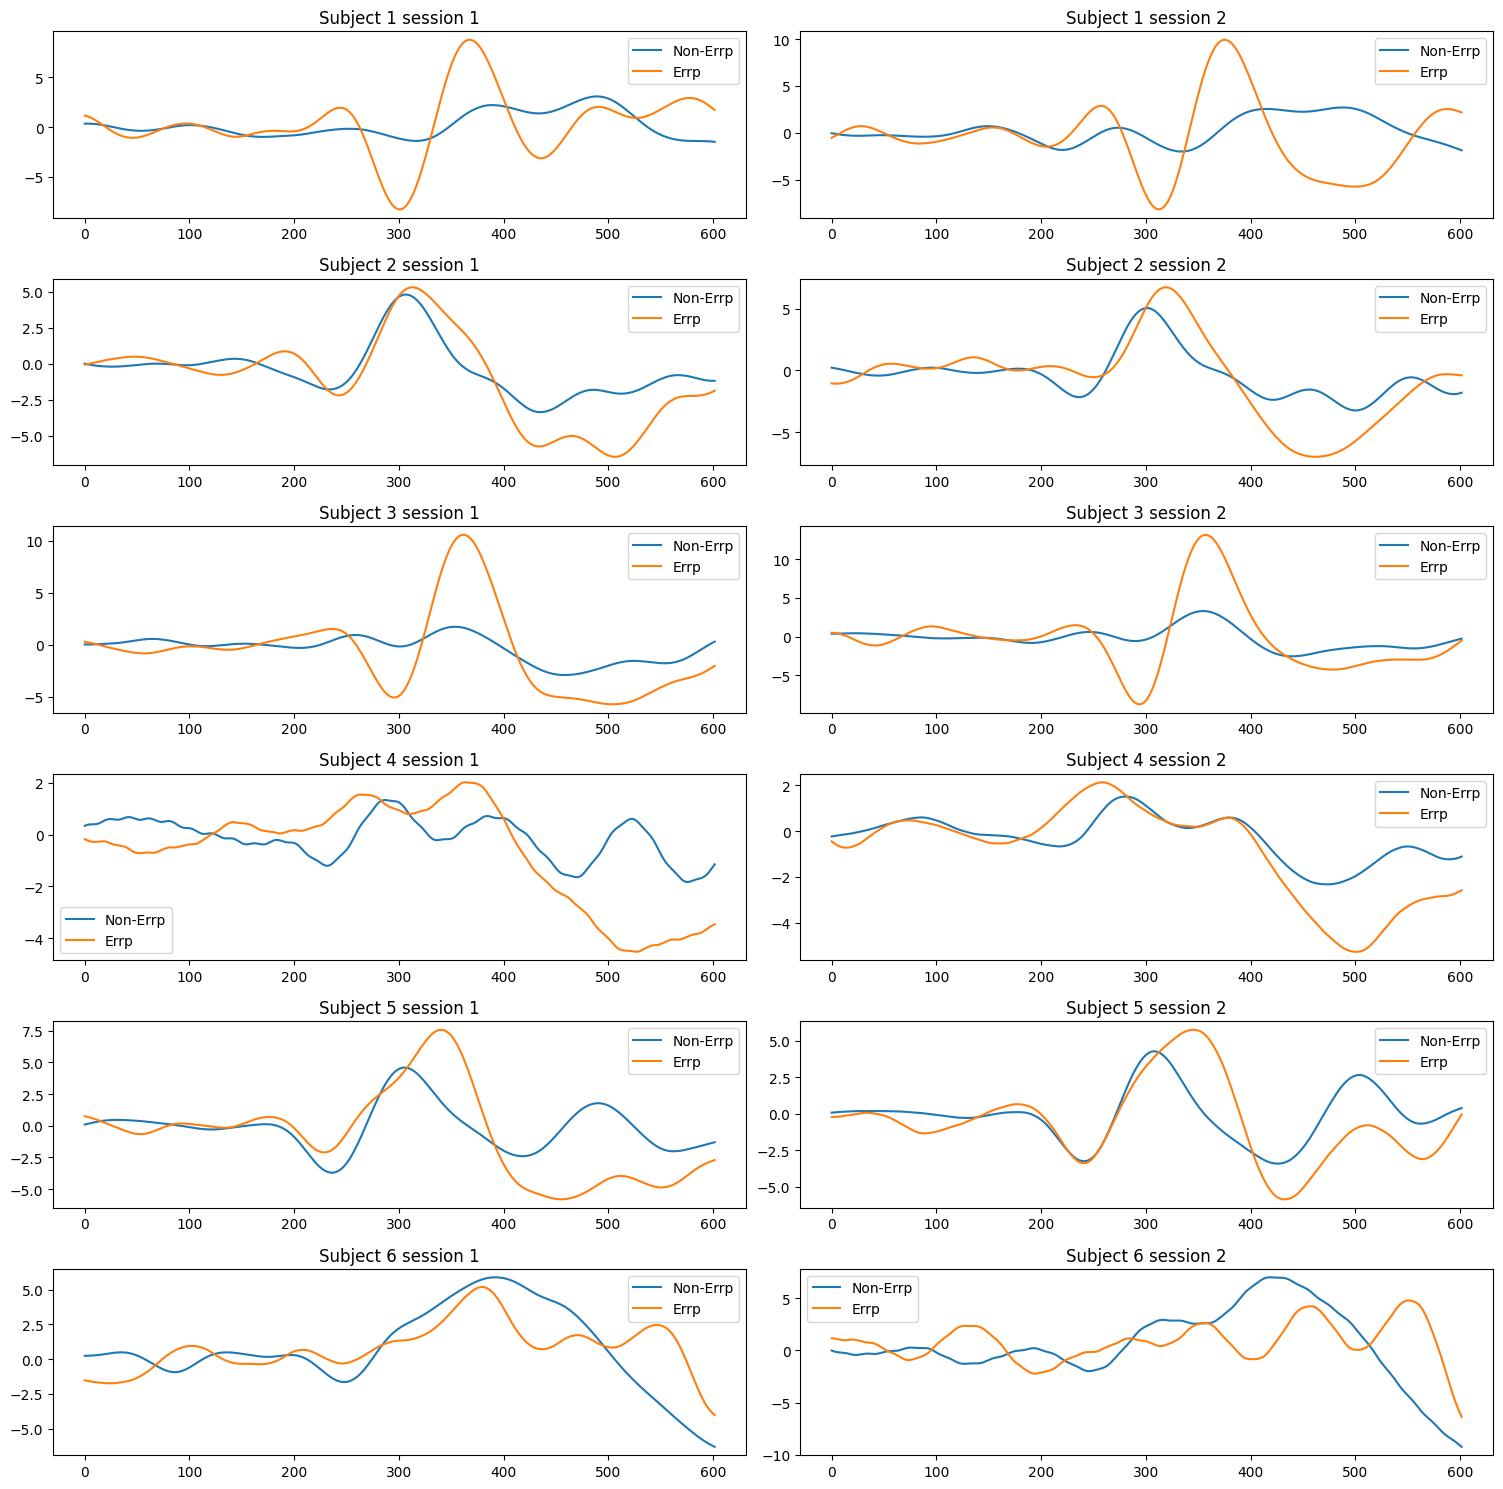

In [45]:
fcz_idx = df.columns.get_loc('FCz')

fcz_len = len(mean_trials[0][0][0][fcz_idx])

duration = fcz_len / 512 * 1000
t = np.linspace(0, duration, fcz_len)

figure, axes = plt.subplots(subjects, sessions, figsize=(15, 15))


for i, subject in enumerate(mean_trials):
    for j, session in enumerate(subject):
        fcz_0 = session[0][fcz_idx]
        fcz_1 = session[1][fcz_idx]

        axes[i, j].plot(t, fcz_0, label='Non-Errp')
        axes[i, j].plot(t, fcz_1, label='Errp')
        axes[i, j].set_title('Subject {subject} session {session}'.format(subject=i + 1, session=j + 1))
        axes[i, j].legend()
       
figure.tight_layout()

Experiment:

In [17]:
comet_logger = CometLogger(
    api_key="WSATCNWE43zphHslQCTsJKcgk",
    workspace="marwo22",  # Optional
    project_name="bachelors-project"  # Optional
)


CometLogger will be initialized in online mode


In [44]:
# Load training module
# The preproccesing code is currently quite messy, still need to clean it up
train, val, test = create_dataset('./src/pickle_df')


Selected test subject: 06


Check the distribution of the two classes in the training, validation and testing set

In [46]:
train_count_1 = np.count_nonzero(np.asarray(train[1]))
val_count_1 = np.count_nonzero(np.asarray(val[1]))
test_count_1 = np.count_nonzero(np.asarray(test[1]))

train_count_0 = len(train[1]) - train_count_1
val_count_0 = len(val[1]) - val_count_1
test_count_0 = len(test[1]) - test_count_1

print('Train occurences: Class 0:', train_count_0, 'Class 1:', train_count_1)
print('Validation occurences: Class 0:', val_count_0, 'Class 1:', val_count_1)
print('Test occurences: Class 0:', test_count_0, 'Class 1:', test_count_1)

Train occurences: Class 0: 3391 Class 1: 3391
Validation occurences: Class 0: 827 Class 1: 222
Test occurences: Class 0: 897 Class 1: 205


In [47]:
dm = DataModule(train=train, val=val, test=test, batch_size=16)


In [48]:
model = EEGNetMultiHeaded(chunk_size=308,
                          num_electrodes=64,
                          dropout=0.5,
                          kernel_1=64,
                          kernel_2=16,
                          F1=8,
                          F2=16,
                          D=2,
                          num_classes=2)


In [49]:
trainer = pl.Trainer(
    max_epochs=50,
    logger=comet_logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training and testing the multi-headed variance-predicting model

In [35]:
trainer.fit(model, datamodule=dm)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/b0e9264541174978986453b6d248d66d



The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Epoch 9: 100%|██████████| 430/430 [00:05<00:00, 81.70it/s, v_num=d66d]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 430/430 [00:05<00:00, 81.58it/s, v_num=d66d]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/b0e9264541174978986453b6d248d66d


COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [4300] : (2.6945810317993164, 10.101201057434082)
COMET INFO:     val_loss [672]    : (2.735635757446289, 8.03445816040039)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (817.39 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)


In [40]:
trainer.test(datamodule=dm)


`.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\b0e9264541174978986453b6d248d66d\checkpoints\epoch=9-step=4300.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at c:\Users\marti_wfv2bf9\Desktop\Bachelors-project\bachelors-project\b0e9264541174978986453b6d248d66d\checkpoints\epoch=9-step=4300.ckpt
The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Testing DataLoader 0: 100%|██████████| 66/66 [00:00<00:00, 74.89it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/b0e9264541174978986453b6d248d66d



Testing DataLoader 0: 100%|██████████| 66/66 [00:02<00:00, 26.97it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22093972508666276    │
│       incorrect_var       │    0.23406944870092403    │
│         test_acc          │    0.8256704807281494     │
│         test_loss         │    2.9768948554992676     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/b0e9264541174978986453b6d248d66d
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22093972508666276
COMET INFO:     incorrect_var : 0.23406944870092403
COMET INFO:     test_acc      : 0.8256704807281494
COMET INFO:     test_loss     : 2.9768948554992676
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 20 metrics, params and output messages


[{'test_acc': 0.8256704807281494,
  'test_loss': 2.9768948554992676,
  'correct_var': 0.22093972508666276,
  'incorrect_var': 0.23406944870092403}]

Training the original one-headed model

In [39]:
test_eeg = test[0]

print(test_eeg[0].shape)
            

(64, 308)


In [41]:
test_shap = list()

shap_test_tensor = torch.empty((0, 1, 64, 308), dtype=torch.float32)

for (data, _) in dm.test_dataloader():
  shap_test_tensor = torch.cat((shap_test_tensor, data), 0)

background = shap_test_tensor[:-10]
print(background.shape)

torch.Size([1034, 1, 64, 308])


In [42]:
e = shap.DeepExplainer(
        (model, model.block1), background)

In [43]:
test_list = shap_test_tensor[-5:]
shap_values = e.shap_values(test_list)

torch.Size([5, 1, 64, 308])


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using non-full backward hooks on a Module that does not take as input a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_input. Please use register_full_backward_hook to get the documented behavior.


RuntimeError: grad can be implicitly created only for scalar outputs

Test runs (10 epochs)

Subject 1
COMET INFO:     correct_var   : 0.24526300002277765
COMET INFO:     incorrect_var : 0.2487000952699538
COMET INFO:     test_acc      : 0.7383260130882263
COMET INFO:     test_loss     : 3.219019651412964

Subject 2
COMET INFO:     correct_var   : 0.2260321459501493
COMET INFO:     incorrect_var : 0.23518400635999237
COMET INFO:     test_acc      : 0.6910856366157532
COMET INFO:     test_loss     : 3.2498958110809326

Subject 3
COMET INFO:     correct_var   : 0.22918819762528056
COMET INFO:     incorrect_var : 0.23405312742954087
COMET INFO:     test_acc      : 0.6031163930892944
COMET INFO:     test_loss     : 3.429486036300659

Subject 4
COMET INFO:     correct_var   : 0.21242563703894976
COMET INFO:     incorrect_var : 0.22683236699740444
COMET INFO:     test_acc      : 0.8202348947525024
COMET INFO:     test_loss     : 2.9433605670928955

Subject 5
COMET INFO:     correct_var   : 0.2306651021589556
COMET INFO:     incorrect_var : 0.2371705954791413
COMET INFO:     test_acc      : 0.774449348449707
COMET INFO:     test_loss     : 3.1388168334960938

Subject 6
COMET INFO:     correct_var   : 0.21972788197611084
COMET INFO:     incorrect_var : 0.2156169066196063
COMET INFO:     test_acc      : 0.5225631594657898
COMET INFO:     test_loss     : 4.015593528747559




Average 0.692 test_acc